<a href="https://colab.research.google.com/github/Kang-Inprogress/-ML/blob/main/%ED%98%BC%EA%B3%B5ML_5%EC%B1%95%ED%84%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 결정 트리

여러개의 노드로 나누어진 트리에서 가장 많은 노드가 해당되는 클래스가 예측 클래스가 된다.

사실 표준화 전처리가 필요없다는 장점이 있다.

In [1]:
import pandas as pd

wine = pd.read_csv("https://bit.ly/wine-date")

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = wine[["alcohol", "sugar", "pH"]].to_numpy()
target = wine[["class"]].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.996921300750433
0.8584615384615385


gini **지니 불순도**

결정 트리의 criterion 매개변수의 기본 값이 'gini'이다. criterion 매개변수는 노드에서 데이터를 분할할 기준을 정한다.


criterion에 지정한 지니 불순도는 분할의 기준이 되며, 1 - (음성 클래스 비율의 제곱 + 양성 클래스 비율의 제곱) 이 된다. 0.5는 최악이며 0이 불순도가 적은 노드이고 이런 노드를 순수 노드라고 한다.

**정보의 이득**

부모 노드와 자식 노드사이에 불순도 차이를 정보 이득이라고 한다.

> **부모의 불순도 - (왼쪽 노드 샘플 수/부모의 샘플 수) x 왼쪽 노드 불순도 - (오른쪽 노드 샘플 수 / 부모의 샘플 수) x 오른쪽 노드 불순도**

결정트리의 기본 알고리즘은 위의 식의 결과 값이 높게 나오게끔 작동한다.


**엔트로피 불순도**

엔트로피 불순도도 지니 불순도와 같이 클래스의 비율을 사용한다. 지니 불순도처럼 제곱이 아니라 밑이 2인 로그를 사용하여 곱한다.

> **-음성 클래스 비율 x log2(음성 클래스 비율) - 양성 클래스 비율 x log2(양성 클래스 비율)**

지니 불순도와 결과값을 그리 다르지 않다. 1에 가깝게 높을 수록 좋지 않은 값이 나올 것이다.




0.8454877814123533
0.8415384615384616


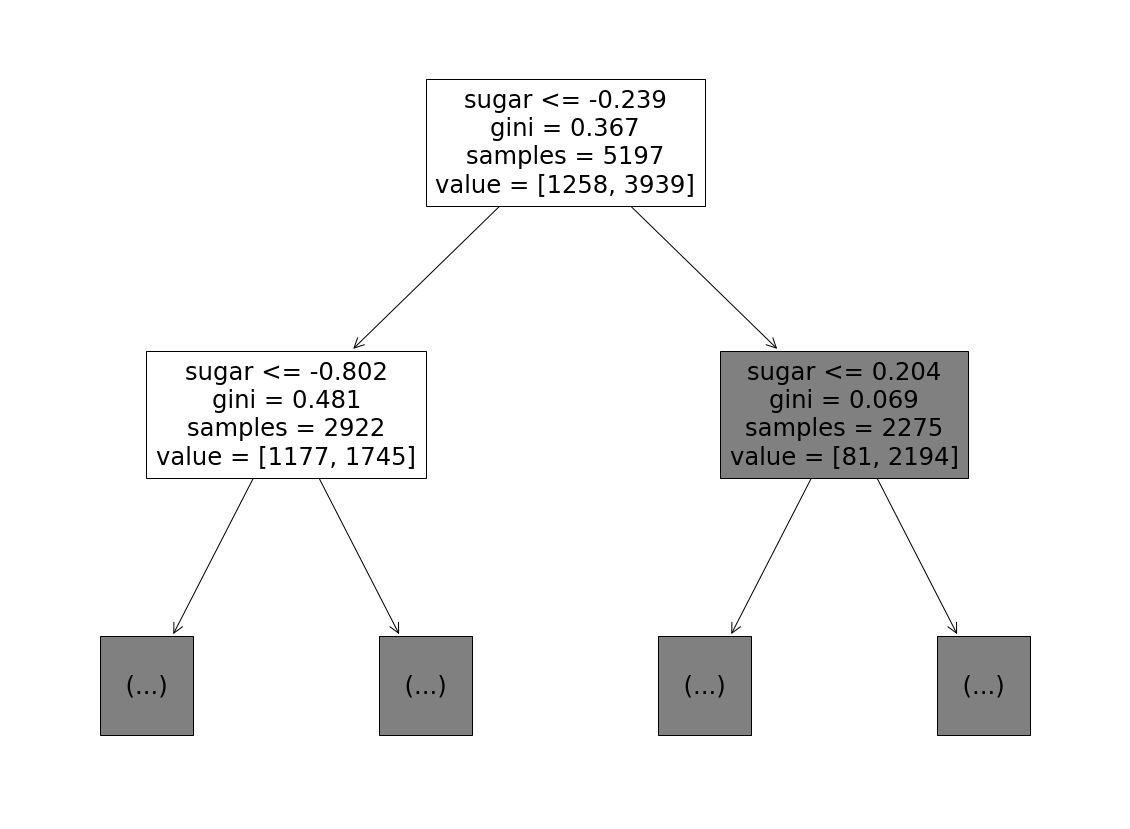

In [ ]:
# 가지치기

dt = DecisionTreeClassifier(max_depth=3, random_state=42) # 깊이(뻗어나갈 수 있는 길이)를 3으로 제한함으로써 과대적합을 방지할 수 있다
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 15))
plot_tree(dt, True, feature_names=["alcohol", "sugar", "pH"])
plt.show()

# 교차 검증과 그리드 서치

In [15]:
# 훈련 세트와 테스트 세트, 검증 세트로 나눔

import numpy as np
from sklearn.model_selection import train_test_split

data = wine[["alcohol", "sugar", "pH"]].to_numpy()
target = wine["class"].to_numpy()

# 훈련 세트와 테스트 세트 나눔
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)
# 훈련 세트와 검증 세트 나눔
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size=0.15, random_state=42)

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.997056825899932
0.8858974358974359


**교차 검증**

In [17]:
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.00870895, 0.00747776, 0.00764227, 0.00752378, 0.00720787]), 'score_time': array([0.00113153, 0.00077605, 0.0007875 , 0.00069571, 0.00072432]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [18]:
import numpy as np
print(np.mean(scores["test_score"])) # 위에서 얻은 샘플 별 검증 점수의 평균

0.855300214703487


In [19]:
from sklearn.model_selection import StratifiedKFold # cv에 사용하게 되면 같은 비율로 골고루 나누어준다

# 10 분할로 섞기
# splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores["test_score"]))

0.855300214703487


**하이퍼파라미터 튜닝**

그리드 서치

In [21]:
from sklearn.model_selection import GridSearchCV

params = {"min_impurity_decrease" : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs= -1)

gs.fit(train_input, train_target) # 데이터 세트에 맞는 최적의 하이퍼파라미터와의 조합으로 훈련을 한다

dt= gs.best_estimator_ # best_estimator_에 그리드 서치로 찾은 최적의 매개변수가 있다
print(dt.score(train_input, train_target))

0.9615162593804117


# 트리의 앙상블 학습

특성 총 개수의 제곱근 갯수만큼 **무작위**로 뽑아서 학습시킨다.

하나의 특성에 과도하게 집중하지 않고 좀 더 많은 특성이 훈련에 기여할 기회를 얻는다. 과대적합을 줄이고 일반화 성능을 높이는 데 도움이 된다.

중복이 허용된 샘플인 부트스트랩 샘플을 사용한다.

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

wine = pd.read_csv("https://bit.ly/wine-date")

data = wine[["alcohol", "sugar", "pH"]].to_numpy()
target = wine[["class"]].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [23]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)

rf.fit(train_input, train_target)
print(rf.feature_importances_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


[0.23167441 0.50039841 0.26792718]


**엑스트라 트리**

부트스트랩 샘플을 사용하지 않는다. 결정 트리를 만들 때 전체 훈련 세트를 사용한다. 대신 노드를 분할할 때 가장 좋은 분할을 찾는 것이 아니라 무작위로 분할한다.

DecisionTreeClassifier의 spitter매개변수를 'random'으로 했을 때와 같다

In [24]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

0.9974503966084433 0.8887848893166506


**그레디언트 부스팅 Gredient Boosting**

깊이가 얕은 결정 트리를 사용하여 이전 트리의 오차를 보완하는 방식으로 앙상블 하는 방법

경사 하강법을 사용하여 트리를 앙상블에 추가합니다. 분류엣는 로지스틱 손실 함수를 사용하고 회귀에서는 평균 제곱 오차 함수를 사용한다.

그레디언트 부스팅은 결정 트리를 계속 추가하면서 손실 함수의 가장 낮은 곳을 찾아 이동한다(학습률 매개변수로 속도를 조절하는 것 또한 같다). 

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

0.8881086892152563 0.8720430147331015


**히스토그램 기반 그레디언트 부스팅 histogram-based Gradient Boosting**



*   입출력 특성을 256개의 구간으로 나눈다. 노드를 분할할 때 최적의 분할을 매우 빠르게 구할 수 있다. 
*   입력에 누락된 특성이 있더라도 따로 전처리 할 필요가 없다.

사이킷런에서는 이 기능을 아직 테스트과정에 있다



In [26]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target, return_train_score=True)
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.9321723946453317 0.8801241948619236


In [27]:
# hgb에서의 특성 중요도 확인
from sklearn.inspection import permutation_importance

hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target, n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.08876275 0.23438522 0.08027708]


# 정리

* 랜덤 포레스트는 앙상블 학습 알고리즘은 성능이 좋고 안정적이기 때문에 첫 번째로 시도해 볼 수 있는 앙상블 학습 중 하나이다.
* 엑스트라 트리는 랜덤 포레스트와 비슷하지만 부트스트랩 샘플을 사용하지않고 노드를 분할할 때 랜덤으로 분할 한다.
* 그레디언트 부스팅은 깊이가 얕은 트리를 연속적으로 추가하여 손실 함수를 최소화하는 앙상블 방법이다. 성능은 좋지만 병렬 연산을 지원하지않아 조금 느리다
* 히스토그램 기반 그레디언트 부스팅은 훈련 데이터를 256개의 구간으로 변환하여 사용하기 때문에 노드 분할 속도가 매우 느리다. 하지만 성능은 매우 뛰어나다. + HGB의 라이브러리인 XGBOsst와 LightGBM이 이미 설치되어 있다(나중에 해 볼것).

